# The (Data) Science of Kpop:   Understanding BTS through Data and A.I.

This notebook will address the following question scientifically: what exactly makes BTS unique in terms of their music and lyrics compared to other k-pop groups? How are they also different compared to American pop musicians? I will answer these questions using both standard and cutting-edge data science techniques.

<h2>$$Contents$$</h2>

* [1. Data Strategy and EDA](#$$1.\-Data\-Strategy\-and\-EDA$$)
    * [1.1 EDA](#1.1-EDA)
* [2. Modeling (Internal Data)](#$$2.\-Modeling$$)
    * [2.1 Baseline Modeling for a BTS Classifier](#2.1-Baseline-Modeling-for-a-BTS-Classifier)
    * [2.2 Feature Importance](#2.2-Feature-Importance)
    * [2.3 Feature Impact](#2.3-Feature-Impact)
* [3. Lyrics and Natural Language Processing](#$$3.\-Lyrics\-and\-Natural\-Language\-Processing$$)
    * [3.1. Doc2Vec with Gensim](#3.1-Doc2Vec-with-Gensim)
    * [3.2. Creating a BTS Classifier (Lyrics)](#3.2-Creating-a-BTS-Classifier)


# $$1.\ Data\ Strategy\ and\ EDA$$

**Data Strategy:** The data strategy for this notebook is as follows:

1) Obtain the musical features of recently popular k-pop groups using Spotify's API. Parse json files in order to store these features in a workable dataframe.

2) Use BeautifulSoup to webscrape translated English lyrics of k-pop songs from these groups. The lyrics will be used for Natural Language Processing and building k-pop classifier using texts.

3) Code for tapping into Spotify API and scraping the web will be stored in a separate python file.

**4) Important: I will take a one-vs.-all approach. As, our target label will be 1 if BTS and 0 if any other group. This will allow for binary classification when building a classifier.**


__Load Modules and CSV__

In [701]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns

plt.style.use('ggplot')

from seaborn import distplot
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import string
from imblearn.over_sampling import SMOTE


%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [702]:
kpop = pd.read_csv('data/kpop_song_features.csv', index_col = 0)
kpop2 = pd.read_csv('data/kpop_song_features2.csv', index_col = 0)
kpop3 = pd.read_csv('data/kpop_song_features3.csv', index_col = 0)

kpop_df = pd.concat([kpop, kpop2, kpop3])
kpop_df = kpop_df[kpop_df.release_date != '0000']

In [715]:
kpop_df['release_date'] = pd.to_datetime(kpop_df['release_date'])
kpop_df['year'] = [i.year for i in kpop_df.release_date]
kpop_df['artist_name'] = [i.lower().replace("'", '') for i in kpop_df.artist_name]

>Extracting the year allows us to analyze evolving musical trends by year

## 1.1 EDA

#### High-level data analysis: correlation, seasonality, and distributions.

In [716]:
kpop_df.head(6)

,danceability,energy,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,release_date,song_name,song_name_formatted,year,target
0,0.637,0.799,2,0.0338,0.3940,0.0,0.0921,0.562,104.995,228615,4,bts,2018-08-24,Euphoria,euphoria,2018,1
1,0.723,0.906,1,0.2790,0.0907,0.0,0.0771,0.398,125.019,225221,4,bts,2018-08-24,Trivia 起 : Just Dance,trivia-just-dance,2018,1
2,0.347,0.578,8,0.0626,0.4450,0.0,0.2310,0.226,86.730,276708,5,bts,2018-08-24,Serendipity (Full Length Edition),serendipity-length,2018,1
3,0.599,0.774,1,0.0541,0.0223,0.0,0.0669,0.696,129.819,223123,4,bts,2018-08-24,DNA,dna,2018,1
4,0.612,0.844,5,0.0756,0.1420,0.0,0.2870,0.653,134.868,196776,4,bts,2018-08-24,Dimple,dimple,2018,1
5,0.761,0.761,5,0.0897,0.2460,0.0,0.1030,0.483,121.972,225698,4,bts,2018-08-24,Trivia 承 : Love,trivia-love,2018,1


Audio Features meaning:

"acousticness": A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

"danceability": Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

"energy": Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.

"instrumentalness": Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. 

"liveness": Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

"loudness": The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. 

"speechiness": Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words

"valence": A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [717]:
kpop_df.artist_name.value_counts()

bigbang             671
shinee              445
bts                 438
ikon                380
girls generation    349
gfriend             123
aoa                 123
red velvet          95 
wanna one           54 
Name: artist_name, dtype: int64

In [720]:
# Again, I will do a one-v-all approach. As such, our target label will be 1 if BTS and 0 if any other group
kpop_df['target'] = [1 if i == 'bts' else 0 for i in kpop_df.artist_name]

In [721]:
kpop_df.corr()['target'].sort_values()

liveness           -0.199258
acousticness       -0.090075
danceability       -0.070142
instrumentalness   -0.062143
time_signature     -0.045011
tempo              -0.013214
energy             -0.010801
valence             0.004409
key                 0.018999
duration_ms         0.025215
year                0.147708
speechiness         0.326600
target              1.000000
Name: target, dtype: float64

>Speechiness and liveness have strong linear relationship with the target variable. We see that speechiness is positively correlated with the target, meaning that as speechiness increases, so does the target variable: being a BTS over being other k-pop groups. Let's just focus on those two features to visualize possible structured relationships between them.

In [738]:
kpop_df.groupby('artist_name').agg({'speechiness':'mean', 'instrumentalness':'mean', 'danceability':'mean', 'energy':'mean','acousticness':'mean', 'valence':'mean'}).sort_values('speechiness', ascending = False)

,speechiness,instrumentalness,danceability,energy,acousticness,valence
artist_name,,,,,,
bts,0.172844,0.012400,0.601454,0.801566,0.118142,0.547792
bigbang,0.108219,0.006586,0.582627,0.832900,0.109640,0.439794
red velvet,0.094951,0.017682,0.668874,0.748158,0.224725,0.627593
wanna one,0.094881,0.000000,0.616815,0.787222,0.199652,0.551296
ikon,0.093867,0.028128,0.630211,0.796621,0.191380,0.517419
shinee,0.083504,0.014346,0.637085,0.807092,0.143948,0.586216
aoa,0.073649,0.098046,0.665081,0.847846,0.159874,0.716894
girls generation,0.072917,0.052389,0.670790,0.797883,0.228858,0.646900
gfriend,0.054407,0.289859,0.617545,0.719066,0.253075,0.530064


>Notice that BTS' songs are the "speechiest" on average by far, almost doubling or tripling songs by other k-pop groups.

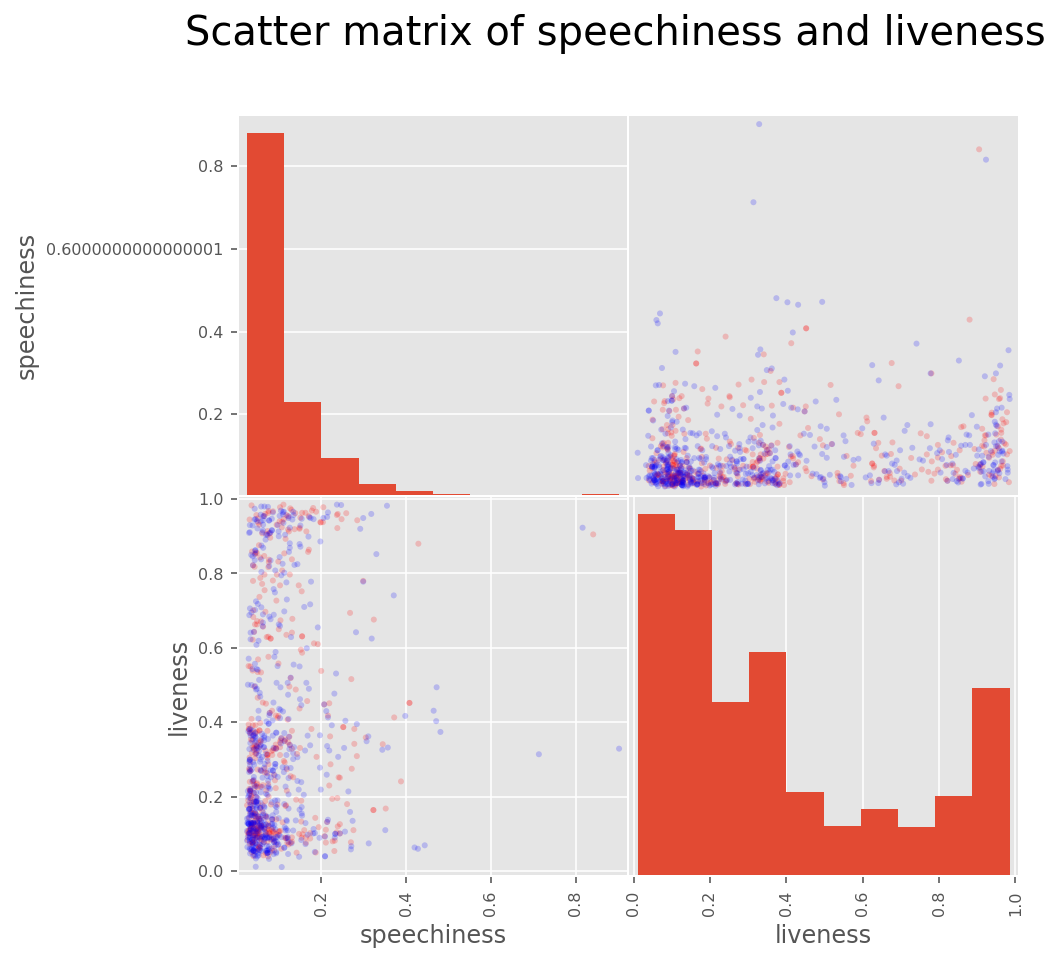

In [734]:
colors = ['red' if ix else 'blue' for ix in kpop_df.target]

scatter_matrix(kpop_df[['speechiness', 'liveness']].sample(1000), alpha = 0.2, figsize = (7,7), diagonal = 'hist', color = colors);
suptitle('Scatter matrix of speechiness and liveness', size = 20);

>The scatter matrix shows that the lower the speechiness, the lower the liveness. The red dots reflect individual BTS songs and the blue dots represent songs from other k-pop groups. Unlike previous analysis through tables, we can't really find the discernment between two target labels through visualization.

#### Focusing specifically on BTS vis-a-vis other k-pop groups

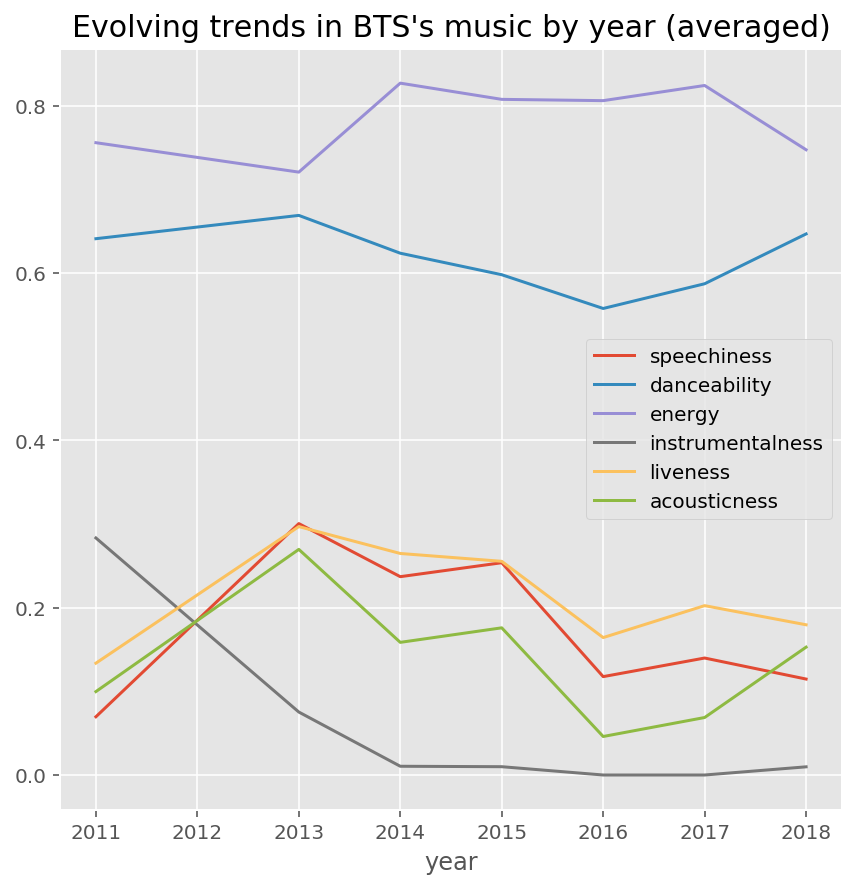

In [751]:
bts_grouped = kpop_df[kpop_df.artist_name == 'bts']
bts_grouped.groupby('year').agg({'speechiness':'mean', 'danceability':'mean', 'energy':'mean', 'instrumentalness':'mean', 'liveness':'mean', 'acousticness':'mean'}).plot(figsize = (7,7));
title('Evolving trends in BTS\'s music by year (averaged)', size = 15);

>Over the years, BTS music has become less and less instrumental to the point where their music no longer has instrumental sounds. This makes sense, since we've seen that BTS' songs have a lot of vocal presence (speechiness), which is inverse to instrumentalness, where "the greater likelihood the track contains no vocal content". Let us see the distribution of all of their features.

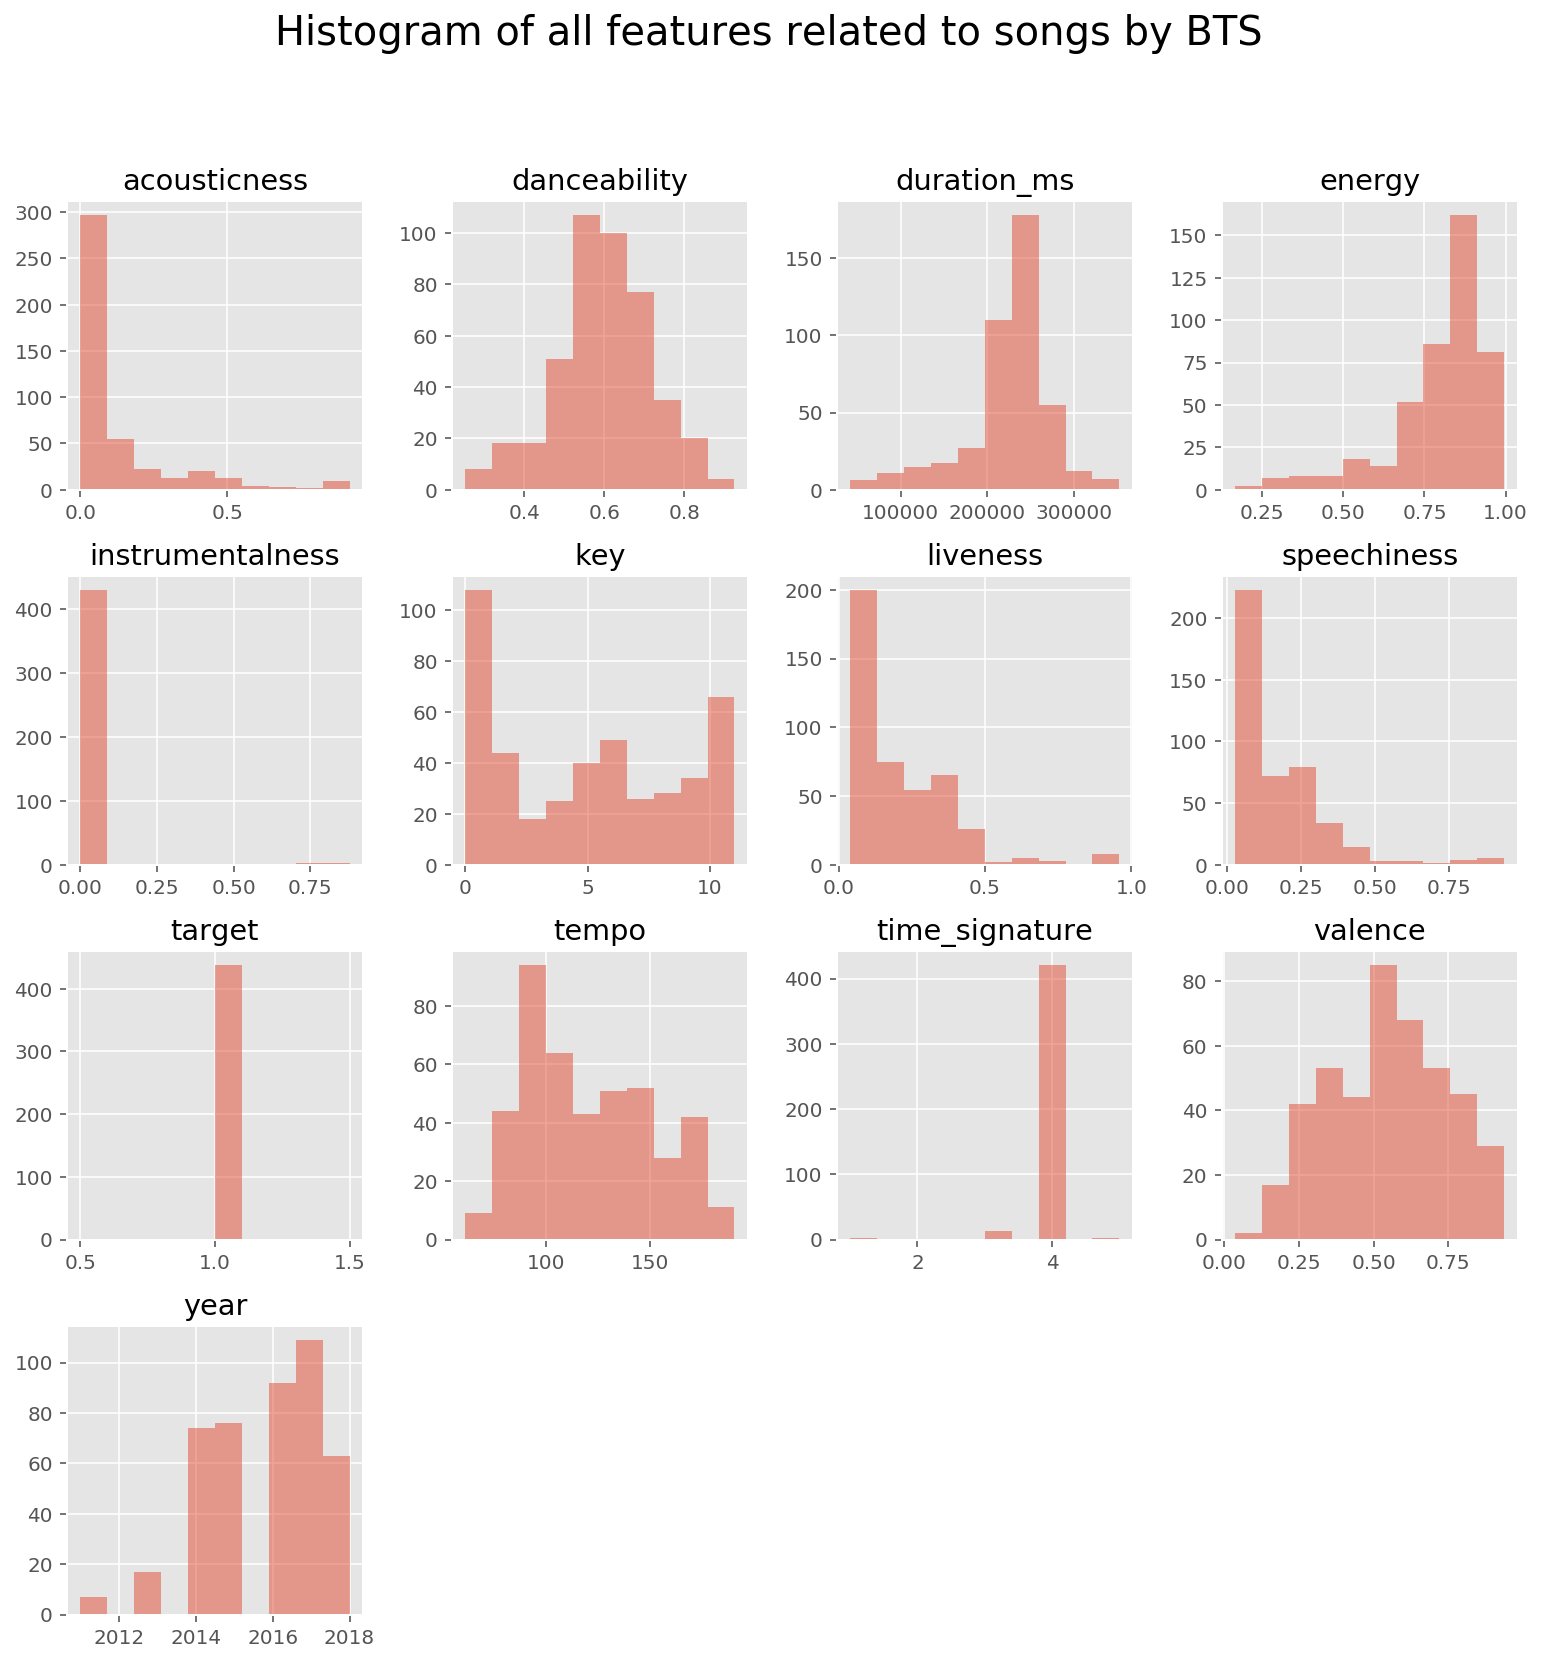

In [770]:
figure = figsize(13,13)
kpop_df[kpop_df.artist_name == 'bts']._get_numeric_data().hist(alpha = 0.5);
suptitle('Histogram of all features related to songs by BTS', size = 20);

These simple histrograms displays important musical qualities: 

1) BTS has been generally producing more music each year. 

2) Their songs are generally well-balanced in valenece (happiness/saddness of a song), tempo, and danceability. 

3) They are low in acousticness, high in energy. Speechiness is interesting here, where on average, the number is high, but in terms of the count, most songs are actually quite lower on the speechiness side. 

In [761]:
bts_tempo = kpop_df[kpop_df['artist_name'] == 'bts']['tempo']  
bigbang_tempo = kpop_df[kpop_df['artist_name'] == 'bigbang']['tempo']  
ikon_tempo = kpop_df[kpop_df['artist_name'] == 'ikon']['tempo']  

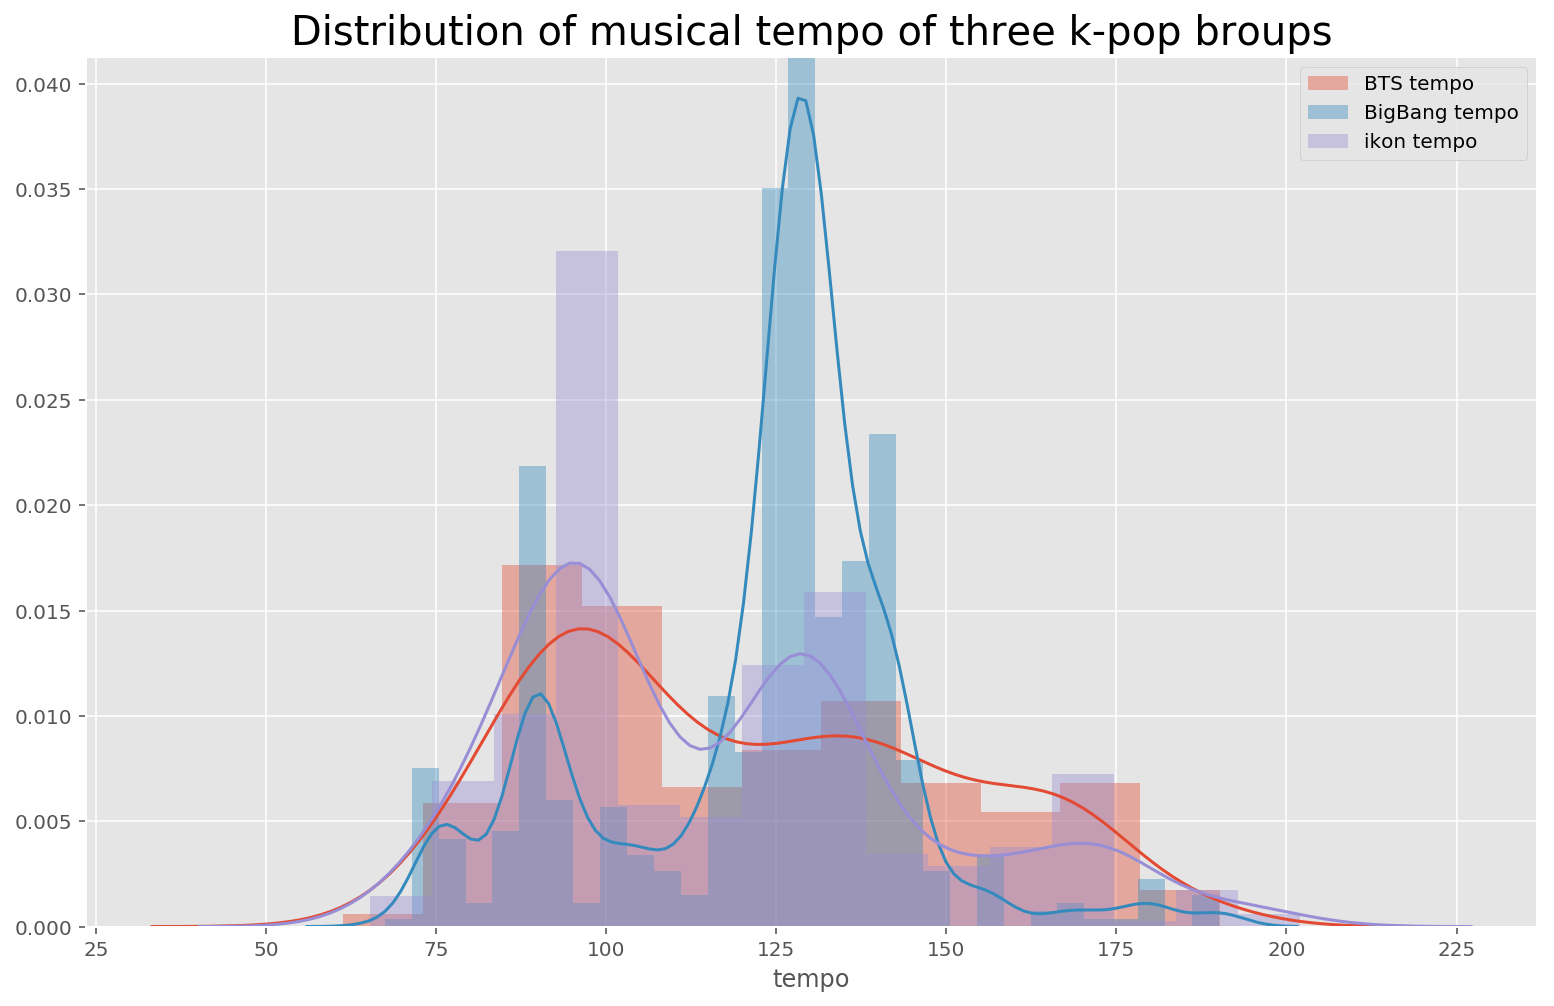

In [765]:
figure = figsize(13,8)
sns.distplot(bts_tempo, label = 'BTS tempo');
sns.distplot(bigbang_tempo, label = 'BigBang tempo');
sns.distplot(ikon_tempo, label = 'ikon tempo');
title('Distribution of musical tempo of three k-pop broups', size = 20)
legend();

>Visualization makes difference between groups all the more transparent. We see that while Big Bang's songs are mostly centered in a tempo of 125 and ikon's songs are centered around 90, BTS's songs are far more diverse and distributed. 

# $$2.\ Modeling$$

## 2.1 Baseline Modeling for a BTS Classifier

A simple baseline model is a good practice to determine a baseline score to improve upon.

I will choose three popular (tree-based) boosting algorithms.

- LIghtGBM Classifier 
- Gradientboost Classifier
- RandomForest Classifier

I will also use a oversampling technique (**SMOTE**) to address the class imbalance issue.

In [771]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import shap
from itertools import combinations


In [774]:
kpop_df.head()

,danceability,energy,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,release_date,song_name,song_name_formatted,year,target
0,0.637,0.799,2,0.0338,0.3940,0.0,0.0921,0.562,104.995,228615,4,bts,2018-08-24,Euphoria,euphoria,2018,1
1,0.723,0.906,1,0.2790,0.0907,0.0,0.0771,0.398,125.019,225221,4,bts,2018-08-24,Trivia 起 : Just Dance,trivia-just-dance,2018,1
2,0.347,0.578,8,0.0626,0.4450,0.0,0.2310,0.226,86.730,276708,5,bts,2018-08-24,Serendipity (Full Length Edition),serendipity-length,2018,1
3,0.599,0.774,1,0.0541,0.0223,0.0,0.0669,0.696,129.819,223123,4,bts,2018-08-24,DNA,dna,2018,1
4,0.612,0.844,5,0.0756,0.1420,0.0,0.2870,0.653,134.868,196776,4,bts,2018-08-24,Dimple,dimple,2018,1


In [775]:
kpop_df_copy = kpop_df.copy()
kpop_df = kpop_df.drop(['artist_name','release_date','year','song_name','song_name_formatted'], 1)

In [776]:
X_train, X_validation, y_train, y_validation = train_test_split(kpop_df.iloc[:,:-1], kpop_df.target, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

In [778]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_sample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('index')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('index')

In [779]:
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
model.fit(X_train_smote, y_train_smote,
           eval_set=[(X_validation_smote, y_validation_smote)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.885397	valid_0's binary_logloss: 0.444532
[400]	valid_0's auc: 0.91402	valid_0's binary_logloss: 0.411125
Early stopping, best iteration is:
[397]	valid_0's auc: 0.913772	valid_0's binary_logloss: 0.411089


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=50, reg_alpha=0.1, reg_lambda=0.1,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

In [791]:
model2 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
model2.fit(X_train_smote, y_train_smote)

validation_pred_proba_grad = model2.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.9113694444444445

In [792]:
model3 = RandomForestClassifier()
model3.fit(X_train_smote,y_train_smote)

validation_pred_proba_grad = model3.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.893612962962963

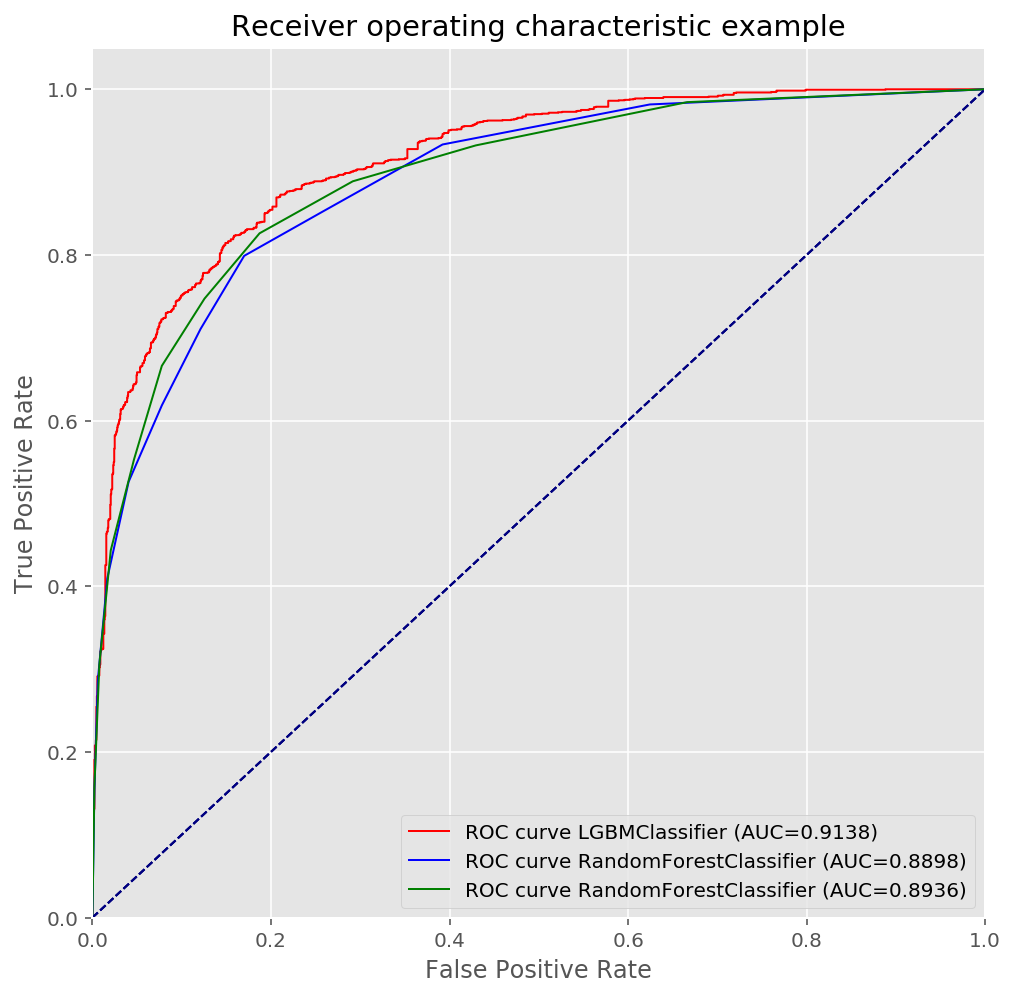

In [797]:
def plot_roc(model, X_validation, y_validation,  color):
    validation_pred_proba = model.predict_proba(X_validation)
    fpr, tpr, thresholds = roc_curve(y_validation, validation_pred_proba[:,1])
    auc = roc_auc_score(y_validation, validation_pred_proba[:,1])

    plt.plot(fpr, tpr, color=color,lw=1, label='ROC curve {} (AUC={:0.4f})'.format(model.__class__.__name__,auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right");
    
figure = figsize(8,8)
plot_roc(model, X_validation_smote, y_validation_smote, 'r')
plot_roc(model2, X_validation_smote, y_validation_smote, 'b')
plot_roc(model3, X_validation_smote, y_validation_smote, 'g')

>Each model is performing phenomenally in terms of AUC score. LGBM performs the best, even though this and every other model has not been optimized. I suspect this has to do with the deterministic aspect of the data, meaning it's not prone to randomness and stochatisticity usually seen in data related to user/consumer behaviors.

## 2.2 Feature Importance

Feature Importance is a traditional algorithm that tells us which features are most important across the entire data. It is therefore called a __global interpretation__ that measures "global" trends, rather than local ones -- the latter of which will be discussed later.

- LGBMClassifier

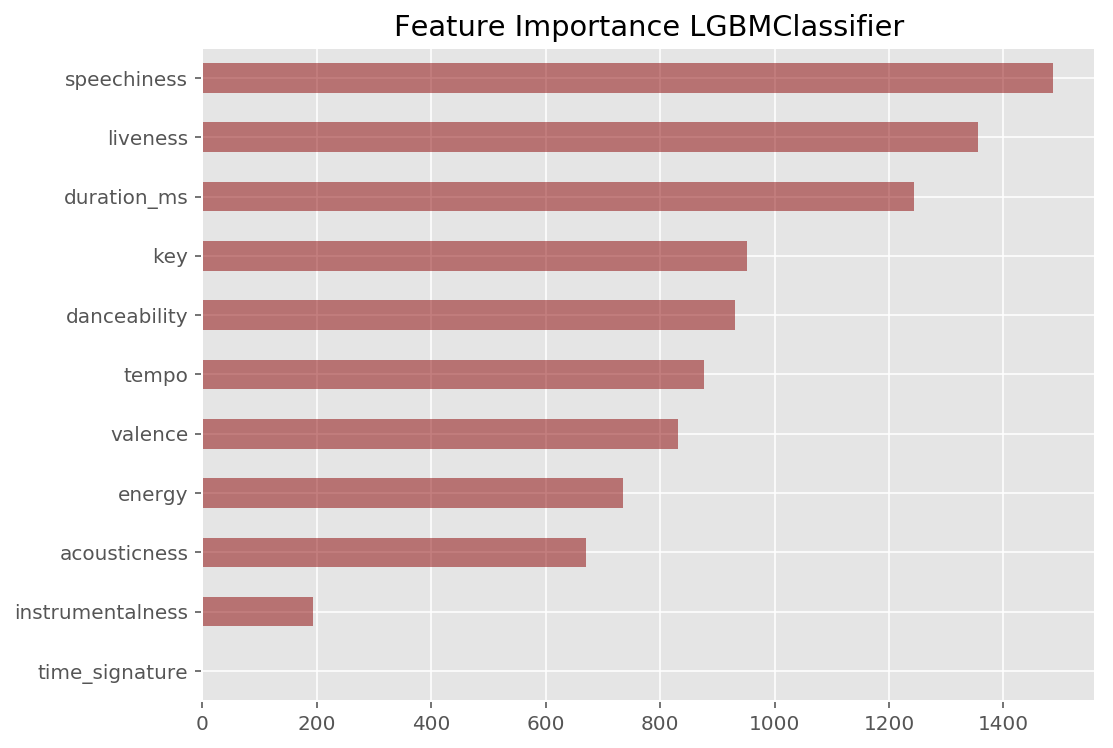

In [799]:
importance_series = pd.Series(data=model.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(8,6), color='darkred', alpha=0.5)
ax.set_title('Feature Importance LGBMClassifier');

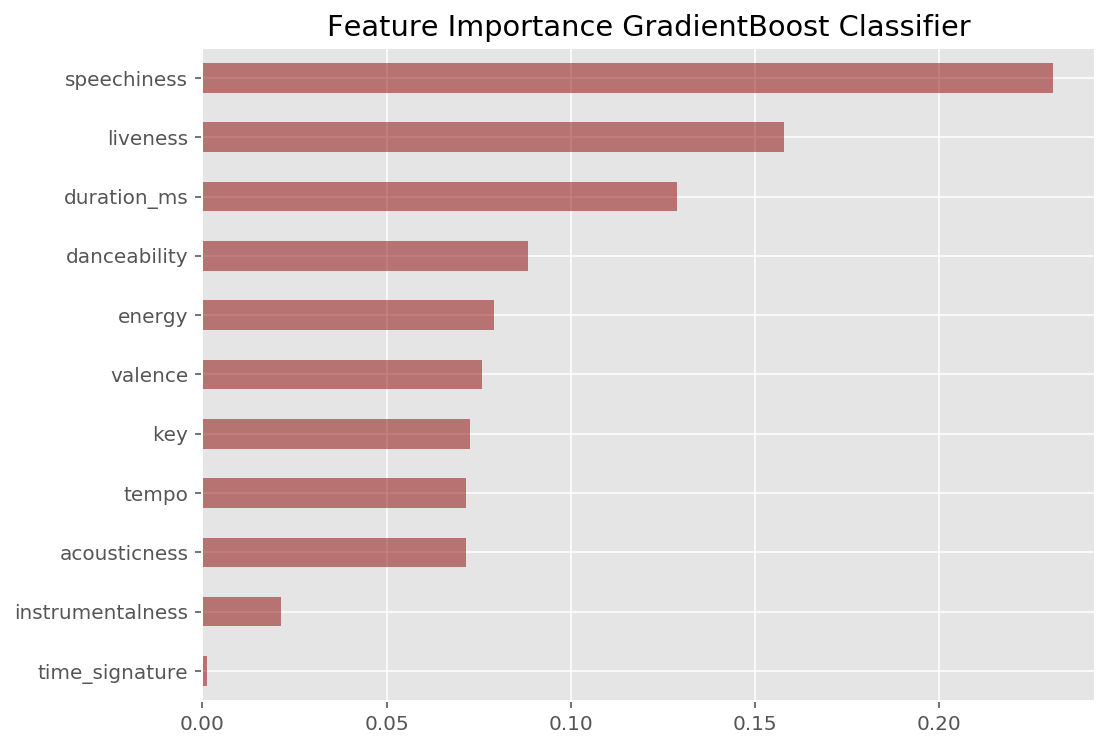

In [801]:
importance_series = pd.Series(data=model2.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(8,6), color='darkred', alpha=0.5)
ax.set_title('Feature Importance GradientBoost Classifier');

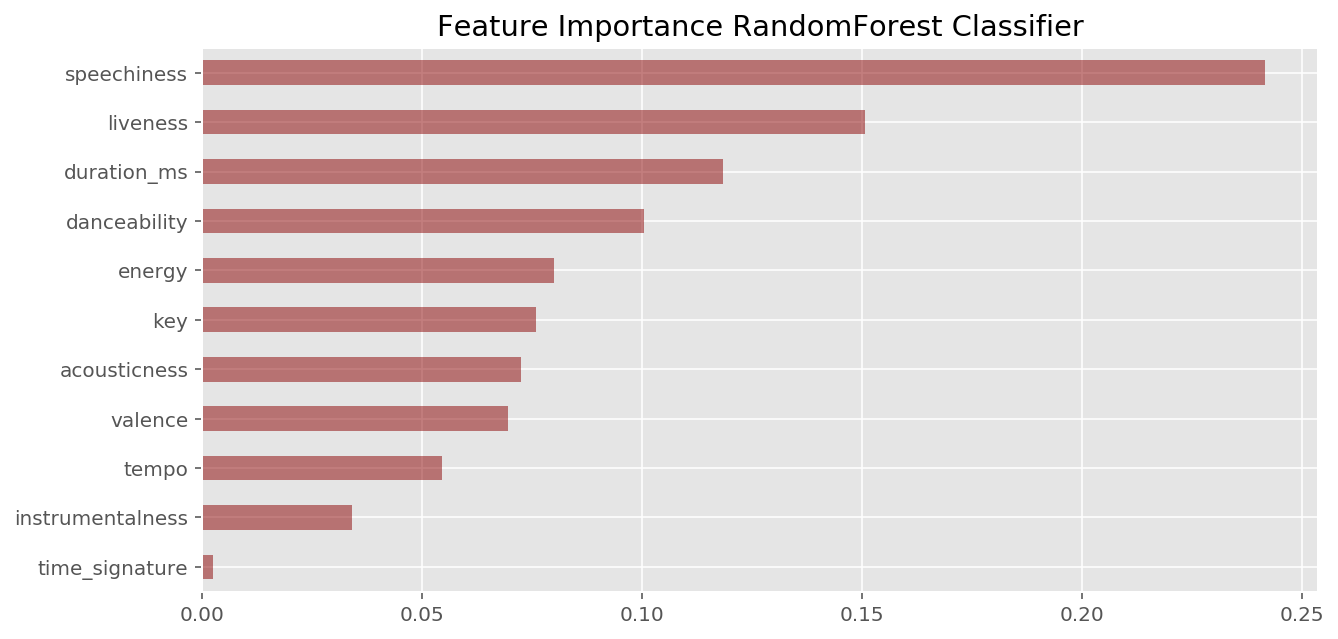

In [803]:
importance_series = pd.Series(data=model3.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(10,5), color='darkred', alpha=0.5)
ax.set_title('Feature Importance RandomForest Classifier');

Feature Importance is a good initial way of measuring feature importance. But there are many problems with this measurement, which I won't go into here. Due to several issues of feature importance, many other metrics have been invented, which I term Feature Impact.

- The Feature Impact of _LightGBMClassifier_ on model output. I base Feature Impact partly on the SHAP values, based on the Shapley value that calculates how much each feature individually contributes to the final prediction, negatively or positively. One huge advantage of SHAP values is their local interpretability, meaning that each individual in our data is also assigned with his/her own SHAP value, allowing analysis on a 'local' level. The charts below will clarify what this means.

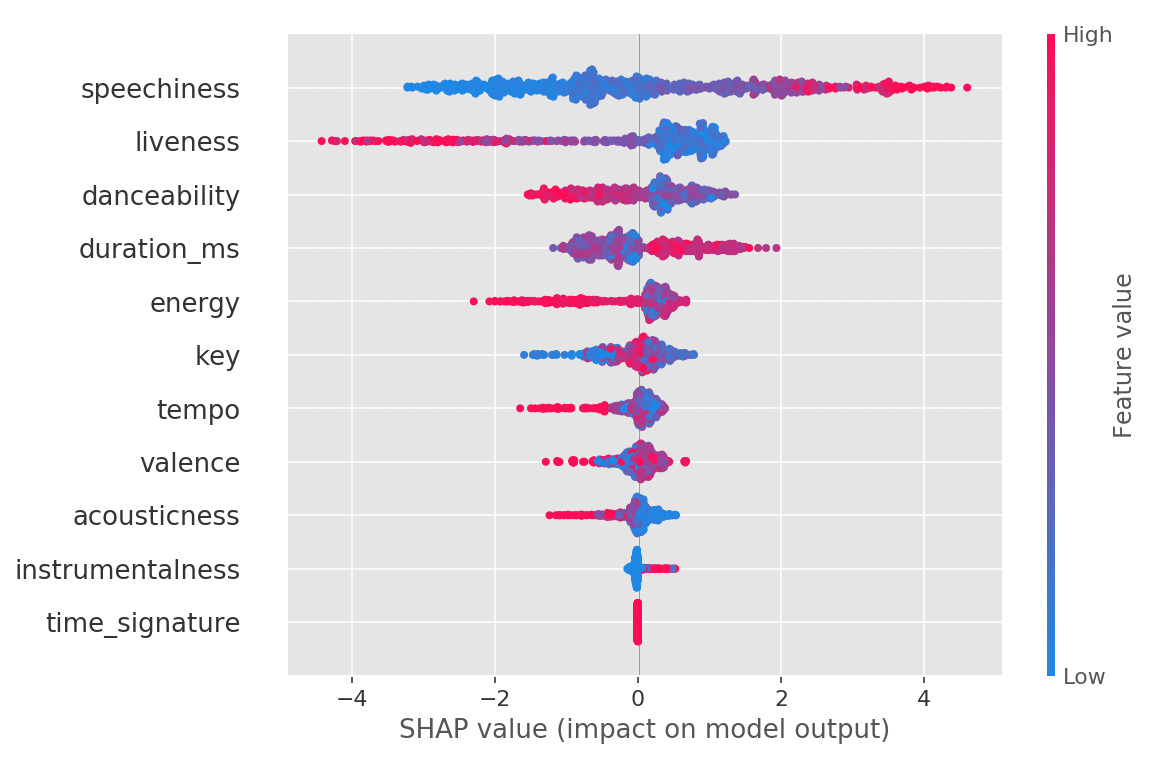

In [805]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

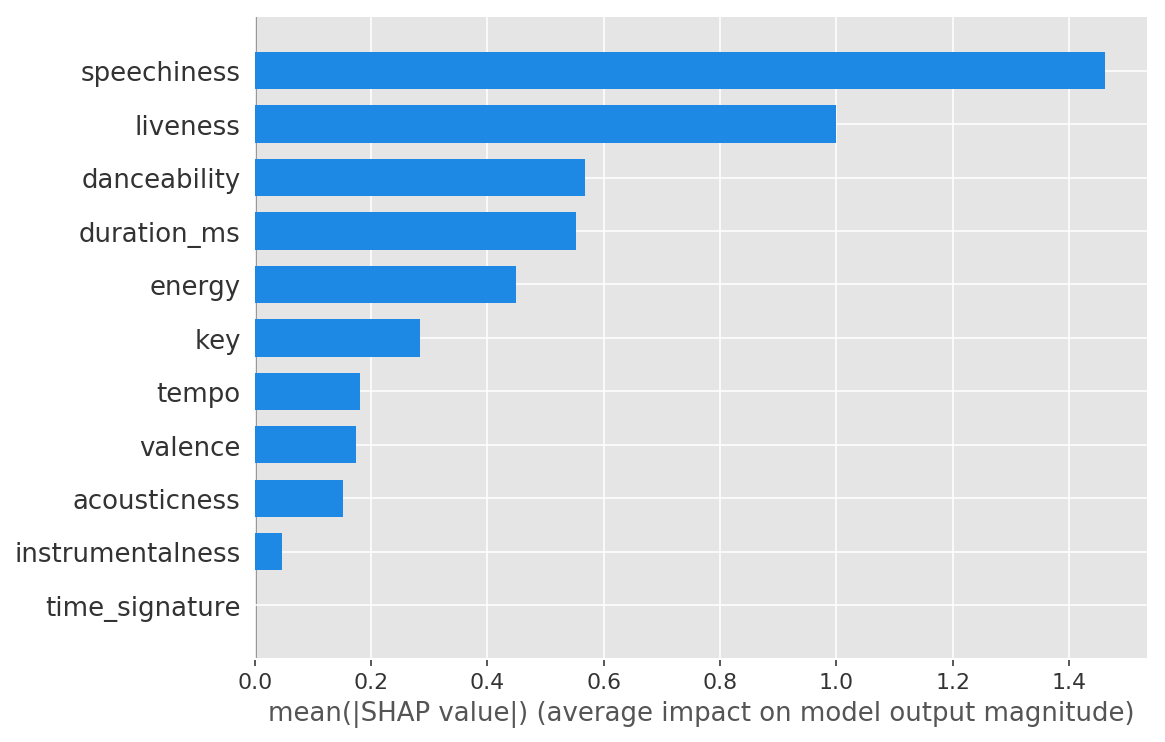

In [807]:
shap.summary_plot(shap_values, X_train_smote, plot_type = "bar")

# $$3.\ Lyrics\ and\ Natural\ Language \ Processing$$

__Load and Clean Textual Data__

In [818]:
# Only will look at Boy Bands, since lyrics can be different based on gender

bts_lyrics = pd.read_csv('lyrics_data/BTS_translated_lyrics.csv', index_col = 0)
shinee = pd.read_csv('lyrics_data/shinee_translated_lyrics.csv', index_col = 0)
exo = pd.read_csv('lyrics_data/exo_translated_lyrics.csv', index_col = 0)
ikon = pd.read_csv('lyrics_data/ikon_translated_lyrics.csv', index_col = 0)
wannaone = pd.read_csv('lyrics_data/wanna-one_translated_lyrics.csv', index_col = 0)
seventeen = pd.read_csv('lyrics_data/seventeen_translated_lyrics.csv', index_col = 0)

all_lyrics_except_bst = [shinee,exo,ikon,wannaone,seventeen]

In [858]:
# again, a one-v-all approach

bts_lyrics['target'] = 1
all_lyrics_except_bts['target'] = 0

In [820]:
all_lyrics = pd.concat([bts_lyrics, all_lyrics_except_bts])

In [821]:
# meta text are things like "(Verse One)" and other texts that aren't part of the lyrics. 
def strip_meta_text(s):
    for i in range(len(s)):
        j = i +1
        try:
            if s[i] == "[":
                while s[j] != "]":
                    j+=1
                s = s.replace(s[i:j +1], '')
            elif s[i] == "(":
                while s[j] != ")":
                    j+=1
                s = s.replace(s[i:j +1], '')
        except Exception as e:
            pass
    return s


In [822]:
all_lyrics.columns = ['name','text','target']

all_lyrics['text'] = all_lyrics['text'].apply(lambda x: x.lower().replace('\n',' '))
all_lyrics['text'] = all_lyrics['text'].apply(lambda x: strip_meta_text(x))

pd.set_option('display.max_colwidth', 0)

all_lyrics['indices'] = range(all_lyrics.shape[0])
all_lyrics.set_index('indices', 1, inplace = True)

all_lyrics['text'] = all_lyrics['text'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

In [832]:
all_lyrics.to_csv('lyrics_data/lyrics.txt')

## 3.1 Doc2Vec with Gensim

Gensim's module provides a handy Word2Vec and Doc2Vec for word embeddings

In [833]:
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec, Word2Vec

# numpy
import numpy

# classifier
from sklearn.linear_model import LogisticRegression

# random
import random

In [859]:
# Tweaking the LabeledLineSentence class to allow separation of labels and a list of words for multiple files

class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [848]:
sources = {'lyrics_data/lyrics.txt':'kpop_lyrics'}

sentences = LabeledLineSentence(sources)

In [849]:
model = Doc2Vec(min_count=1, window=10, size=150, sample=1e-4, negative=5, workers=7)

# model.build_vocab(sentences.to_array())
 
# model.train(sentences.sentences_perm(), total_examples=model.corpus_count, epochs= 2000)

# model.save('data/doc2vecmodel')

gensim_model = gensim.models.Doc2Vec.load('data/doc2vecmodel')

print(gensim_model.most_similar('dance'))

[('dancing', 0.3933735191822052), ('engine', 0.33794981241226196), ('bu', 0.3313860297203064), ('bounce', 0.3074822425842285), ('kia', 0.3053484261035919), ('barbie', 0.3019580543041229), ('ken', 0.30177754163742065), ('wassup', 0.2976495623588562), ('despite', 0.29637792706489563), ('video', 0.2915126085281372)]


## 3.2 Creating a BTS Classifier

In [850]:
train_arrays = np.zeros((all_lyrics.shape[0], gensim_model['kpop_lyrics_0'].shape[0]))
train_labels = np.array(all_lyrics.target)

for i in range(all_lyrics.text.shape[0]):
    train_arrays[i] = model['kpop_lyrics_' + str(i)]

In [852]:
x_train, x_test, y_train, y_test = train_test_split(train_arrays, train_labels, test_size = 0.2, random_state = 42)    

In [853]:
classifier = LogisticRegression()


classifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [854]:
y_pred = classifier.predict(x_test)

accuracy_score(y_test,y_pred)

0.9615384615384616

In [855]:
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1)
model.fit(x_train, y_train,
           eval_set=[(x_test, y_test)],
           early_stopping_rounds=10000,
eval_metric='auc',
verbose=200,)

Training until validation scores don't improve for 10000 rounds.
[200]	valid_0's auc: 0.816568	valid_0's binary_logloss: 0.539677
[400]	valid_0's auc: 0.83432	valid_0's binary_logloss: 0.504463
[600]	valid_0's auc: 0.857988	valid_0's binary_logloss: 0.504878
[800]	valid_0's auc: 0.863905	valid_0's binary_logloss: 0.496524
[1000]	valid_0's auc: 0.87574	valid_0's binary_logloss: 0.486399
[1200]	valid_0's auc: 0.893491	valid_0's binary_logloss: 0.485379
[1400]	valid_0's auc: 0.887574	valid_0's binary_logloss: 0.488999
[1600]	valid_0's auc: 0.887574	valid_0's binary_logloss: 0.494677
[1800]	valid_0's auc: 0.887574	valid_0's binary_logloss: 0.494535
[2000]	valid_0's auc: 0.893491	valid_0's binary_logloss: 0.490094
[2200]	valid_0's auc: 0.899408	valid_0's binary_logloss: 0.489213
[2400]	valid_0's auc: 0.899408	valid_0's binary_logloss: 0.491874
[2600]	valid_0's auc: 0.899408	valid_0's binary_logloss: 0.495122
[2800]	valid_0's auc: 0.899408	valid_0's binary_logloss: 0.495122
[3000]	valid_0's 

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.1,
        reg_lambda=0.1, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=0)

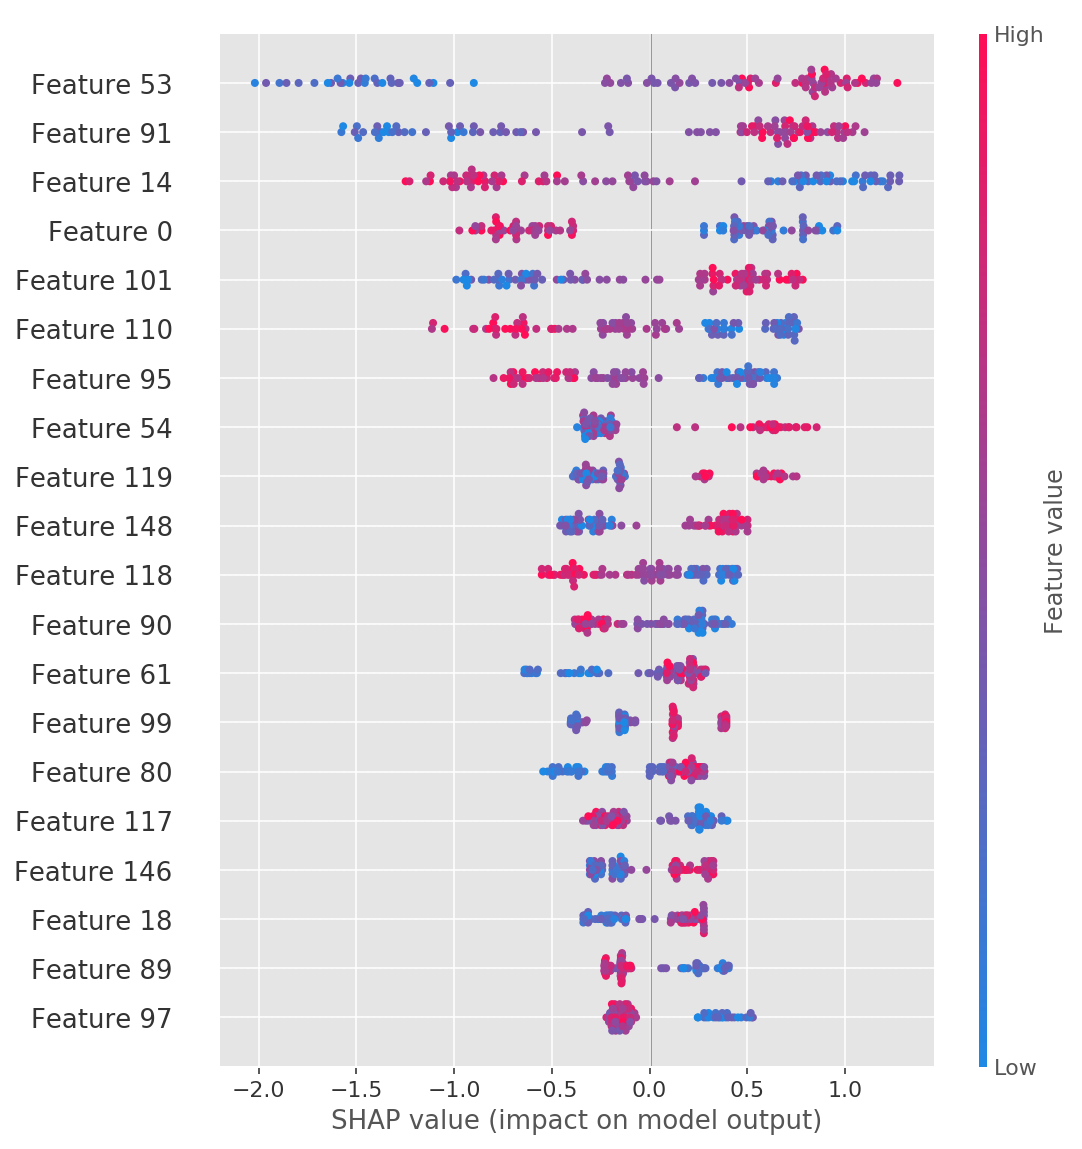

In [869]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train)

## The last part is a work in progress. I will focus on Ida2Vec which allows for thematic extractions from texts, as well as other models that allow for model interpretability 

# (Unfinished) Comparing Korean pop with American Pop

In [865]:
apop = pd.read_csv('data/apop_song_features.csv', index_col = 0)
apop2 = pd.read_csv('data/apop_song_features2.csv', index_col = 0)
apop3 = pd.read_csv('data/apop_song_features3.csv', index_col = 0)

apop_df = pd.concat([apop, apop2, apop3])
apop_df = apop_df[apop_df.release_date != '0000']

apop_df['artist_name'] = [i.lower().replace("'", '') for i in apop_df.artist_name]

In [866]:
apop_df['release_date'] = pd.to_datetime(apop_df['release_date'])
apop_df['year'] = [i.year for i in apop_df.release_date]

In [867]:

kpop_df['target'] = 1
apop_df['target'] = 0

In [ ]:
df = pd.concat([kpop_df, apop_df])

In [ ]:
pd.concat([kpop_df.artist_name.value_counts(), apop_df.artist_name.value_counts()])


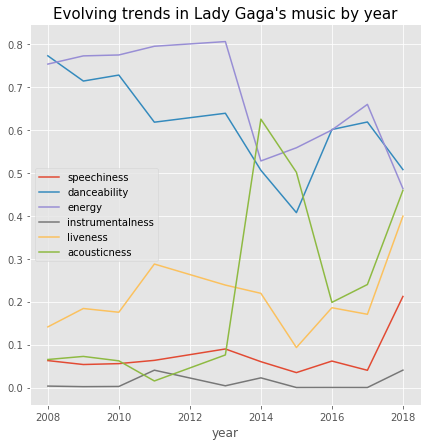

In [14]:
ladygaga_grouped = apop_df[apop_df.artist_name == 'lady gaga']
ladygaga_grouped.groupby('year').agg({'speechiness':'mean', 'danceability':'mean', 'energy':'mean', 'instrumentalness':'mean', 'liveness':'mean', 'acousticness':'mean'}).plot(figsize = (7,7));
title('Evolving trends in Lady Gaga\'s music by year', size = 15);

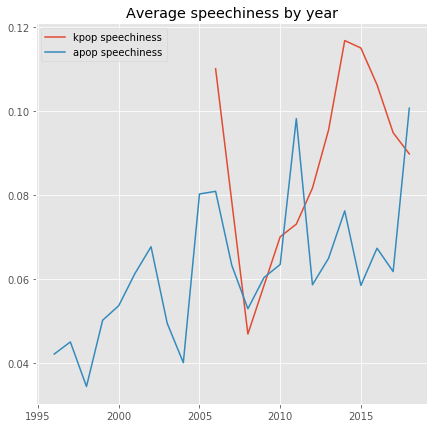

In [28]:
figure = figsize(7,7)
plt.subplot(1, 1, 1)
plot(kpop_df.groupby('year').agg({'speechiness':'mean'}), label = 'kpop speechiness');

plt.subplot(1, 1, 1)
plot(apop_df.groupby('year').agg({'speechiness':'mean'}), label = 'apop speechiness');
title('Average speechiness by year')
legend();

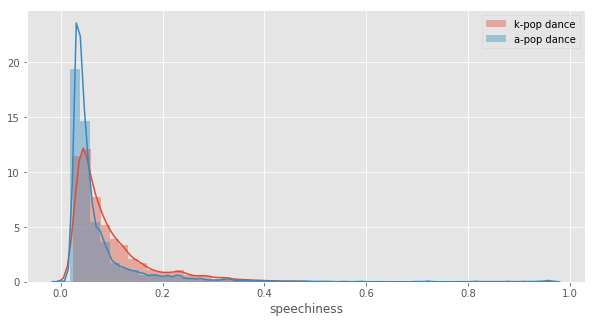

In [29]:
figure = figsize(10,5)
sns.distplot(df[df.target == 1]['speechiness'], label = 'k-pop dance');
sns.distplot(df[df.target == 0]['speechiness'], label = 'a-pop dance');
legend();

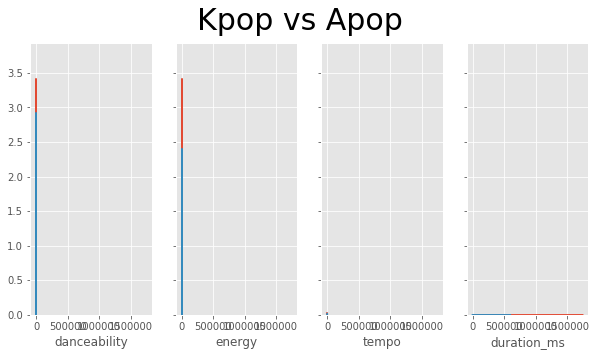

In [30]:
f, axes = subplots(1, 4, figsize=(10, 5), sharex=True, sharey = True)

sns.distplot(df[df.target == 1][df.columns[0]], ax = axes[0]);
sns.distplot(df[df.target == 0][df.columns[0]], ax = axes[0]);

sns.distplot(df[df.target == 1][df.columns[1]], ax = axes[1]);
sns.distplot(df[df.target == 0][df.columns[1]], ax = axes[1]);

sns.distplot(df[df.target == 1][df.columns[8]], ax = axes[2]);
sns.distplot(df[df.target == 0][df.columns[8]], ax = axes[2]);

sns.distplot(df[df.target == 1][df.columns[9]], ax = axes[3]);
sns.distplot(df[df.target == 0][df.columns[9]], ax = axes[3]);

suptitle('Kpop vs Apop', fontsize = 30);

# Modeling with Automated feature engineering to distinguish Kpop from Apop

In [31]:
import featuretools as ft
import featuretools.variable_types as vtypes

es = ft.EntitySet(id = 'passengers')

In [32]:
y = df.target
df = df.drop(['artist_name','release_date','year', 'target'], 1)


In [33]:
df_types = {}

for col in df:
    if (df[col].nunique() == 2) and (df[col].dtype == int or df[col].dtype == float):
        df_types[col] = vtypes.Boolean
    elif (df[col].nunique() != 2) and (df[col].dtype == int or df[col].dtype == float):
        df_types[col] = vtypes.Numeric
        
df_types['key'] = vtypes.Ordinal

In [34]:
df_types

{'danceability': featuretools.variable_types.variable.Numeric,
 'energy': featuretools.variable_types.variable.Numeric,
 'key': featuretools.variable_types.variable.Ordinal,
 'speechiness': featuretools.variable_types.variable.Numeric,
 'acousticness': featuretools.variable_types.variable.Numeric,
 'instrumentalness': featuretools.variable_types.variable.Numeric,
 'liveness': featuretools.variable_types.variable.Numeric,
 'valence': featuretools.variable_types.variable.Numeric,
 'tempo': featuretools.variable_types.variable.Numeric,
 'duration_ms': featuretools.variable_types.variable.Numeric,
 'time_signature': featuretools.variable_types.variable.Numeric}

In [35]:
es = es.entity_from_dataframe(entity_id = 'df', dataframe = df, variable_types = df_types, index = 'indices')

2018-10-10 09:57:03,270 featuretools.entityset - WARNING    index indices not found in dataframe, creating new integer column


In [36]:
es

Entityset: passengers
  Entities:
    df [Rows: 11145, Columns: 12]
  Relationships:
    No relationships

In [37]:
primitives = ft.list_primitives()

print('List of transformation primitives: {}'.format(list(primitives[primitives['type'] == 'transform'].name.values)))

List of transformation primitives: ['percentile', 'month', 'weeks', 'minute', 'cum_max', 'minutes', 'time_since', 'cum_mean', 'seconds', 'subtract', 'years', 'hour', 'diff', 'longitude', 'characters', 'add', 'negate', 'absolute', 'day', 'divide', 'months', 'days_since', 'weekday', 'cum_min', 'week', 'is_null', 'cum_count', 'year', 'numwords', 'multiply', 'weekend', 'haversine', 'not', 'hours', 'cum_sum', 'or', 'second', 'days', 'latitude', 'time_since_previous', 'mod', 'and', 'isin']


In [38]:
agg_primitives = primitives[primitives['type'] == 'aggregation'].name.values
trans_primitives = ['percentile', 'and', 'or','subtract']

feature_names = ft.dfs(entityset = es, target_entity = 'df',
                       trans_primitives = trans_primitives,
                       agg_primitives= agg_primitives, 
                       where_primitives = [], seed_features = [],
                       max_depth = 2, n_jobs = -1, verbose = 1,
                       features_only=True)

Built 401 features


In [39]:
feature_matrix = ft.calculate_feature_matrix(feature_names, 
                                                 entityset=es, 
                                                 n_jobs = 1, 
                                                 verbose = 0,
                                                 chunk_size = es['df'].df.shape[0])

In [40]:
feature_matrix.shape

(11145, 401)

In [41]:
feature_matrix.head()

,danceability,energy,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,PERCENTILE(danceability),PERCENTILE(energy),PERCENTILE(speechiness),PERCENTILE(acousticness),PERCENTILE(instrumentalness),PERCENTILE(liveness),PERCENTILE(valence),PERCENTILE(tempo),PERCENTILE(duration_ms),PERCENTILE(time_signature),tempo - liveness,tempo - duration_ms,liveness - danceability,valence - duration_ms,time_signature - speechiness,speechiness - duration_ms,danceability - valence,acousticness - danceability,liveness - duration_ms,valence - acousticness,time_signature - danceability,speechiness - acousticness,instrumentalness - duration_ms,liveness - acousticness,duration_ms - danceability,valence - speechiness,liveness - energy,acousticness - duration_ms,danceability - speechiness,speechiness - valence,instrumentalness - liveness,acousticness - valence,acousticness - energy,duration_ms - instrumentalness,danceability - tempo,energy - instrumentalness,tempo - danceability,energy - acousticness,speechiness - liveness,...,PERCENTILE(tempo) - PERCENTILE(valence),PERCENTILE(energy) - PERCENTILE(valence),time_signature - PERCENTILE(valence),PERCENTILE(valence) - PERCENTILE(acousticness),PERCENTILE(time_signature) - speechiness,PERCENTILE(energy) - speechiness,PERCENTILE(instrumentalness) - PERCENTILE(energy),PERCENTILE(acousticness) - PERCENTILE(liveness),PERCENTILE(duration_ms) - PERCENTILE(danceability),PERCENTILE(tempo) - PERCENTILE(duration_ms),PERCENTILE(duration_ms) - time_signature,PERCENTILE(instrumentalness) - instrumentalness,PERCENTILE(instrumentalness) - PERCENTILE(speechiness),PERCENTILE(energy) - instrumentalness,PERCENTILE(energy) - PERCENTILE(speechiness),PERCENTILE(acousticness) - valence,PERCENTILE(energy) - time_signature,time_signature - PERCENTILE(duration_ms),PERCENTILE(speechiness) - valence,PERCENTILE(acousticness) - instrumentalness,PERCENTILE(acousticness) - PERCENTILE(speechiness),PERCENTILE(valence) - speechiness,instrumentalness - PERCENTILE(time_signature),PERCENTILE(speechiness) - PERCENTILE(time_signature),time_signature - PERCENTILE(energy),acousticness - PERCENTILE(tempo),PERCENTILE(liveness) - PERCENTILE(valence),PERCENTILE(instrumentalness) - danceability,PERCENTILE(valence) - PERCENTILE(time_signature),PERCENTILE(duration_ms) - valence,energy - PERCENTILE(instrumentalness),PERCENTILE(valence) - PERCENTILE(tempo),tempo - PERCENTILE(speechiness),liveness - PERCENTILE(energy),PERCENTILE(tempo) - energy,PERCENTILE(danceability) - instrumentalness,PERCENTILE(danceability) - PERCENTILE(speechiness),PERCENTILE(tempo) - tempo,PERCENTILE(valence) - acousticness,PERCENTILE(energy) - duration_ms,PERCENTILE(danceability) - PERCENTILE(liveness),speechiness - PERCENTILE(energy),PERCENTILE(valence) - energy,valence - PERCENTILE(energy),PERCENTILE(danceability) - acousticness,PERCENTILE(speechiness) - energy,liveness - PERCENTILE(valence),PERCENTILE(valence) - PERCENTILE(danceability),PERCENTILE(danceability) - PERCENTILE(energy),PERCENTILE(time_signature) - PERCENTILE(duration_ms)
indices,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.714,0.736,2,0.0457,0.1910,0.000000,0.0553,0.814,149.985,210818,4,0.743248,0.441050,0.420458,0.710677,0.302647,0.041857,0.875415,0.863033,0.327322,0.517766,149.9297,-210668.015,-0.6587,-210817.186,3.9543,-210817.9543,-0.100,-0.5230,-210817.9447,0.6230,3.286,-0.1453,-210818.000000,-0.1357,210817.286,0.7683,-0.6807,-210817.8090,0.6683,-0.7683,-0.055300,-0.6230,-0.5450,210818.000000,-149.271,0.736000,149.271,0.5450,-0.0096,...,-0.012382,-0.434365,3.124585,0.164738,0.472066,0.395350,-0.138403,0.668820,-0.415926,0.535711,-3.672678,0.302647,-0.117811,0.441050,0.020592,-0.103323,-3.558950,3.672678,-0.393542,0.710677,0.290220,0.829715,-0.517766,-0.097308,3.558950,-0.672033,-0.833558,-0.411353,0.357649,-0.486678,0.433353,0.012382,149.564542,-0.385750,0.127033,0.743248,0.322790,-149.121967,0.684415,-210817.558

In [97]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import shap
from itertools import combinations


In [43]:
X_train, X_validation, y_train, y_validation = train_test_split(feature_matrix, y, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

In [49]:
X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_sample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('indices')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('indices')


model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
model.fit(X_train_smote, y_train_smote,
           eval_set=[(X_validation_smote, y_validation_smote)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.883979	valid_0's binary_logloss: 0.449699
[400]	valid_0's auc: 0.903836	valid_0's binary_logloss: 0.396577
[600]	valid_0's auc: 0.91146	valid_0's binary_logloss: 0.378531
[800]	valid_0's auc: 0.915736	valid_0's binary_logloss: 0.371155
Early stopping, best iteration is:
[871]	valid_0's auc: 0.916836	valid_0's binary_logloss: 0.369934


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=50, reg_alpha=0.1, reg_lambda=0.1,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

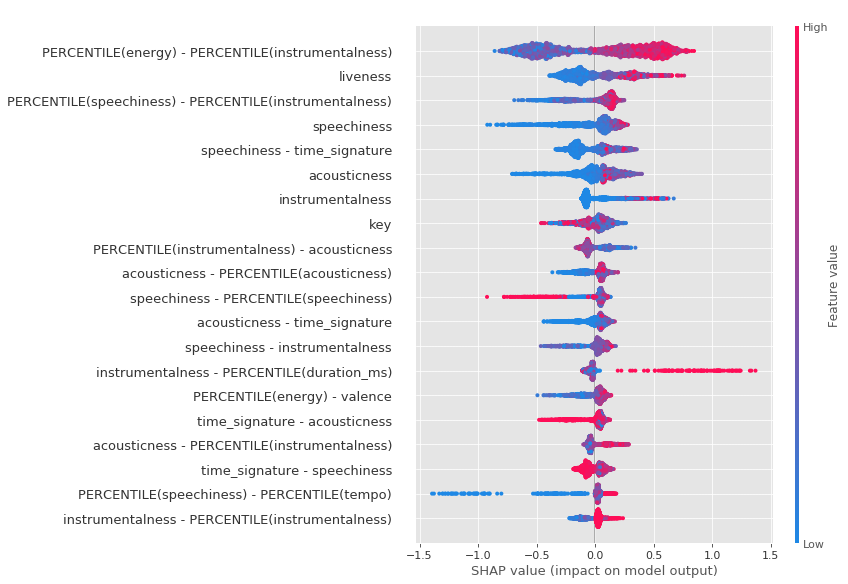

In [50]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

In [67]:
top_features = ['PERCENTILE(energy) - PERCENTILE(instrumentalness)', 'liveness','PERCENTILE(speechiness) - PERCENTILE(instrumentalness)','speechiness','speechiness - time_signature','acousticness','instrumentalness','key','PERCENTILE(instrumentalness) - acousticness','acousticness - PERCENTILE(acousticness)', 'speechiness - PERCENTILE(speechiness)', 'acousticness - time_signature']


In [68]:
filtered_df = feature_matrix[top_features]

In [71]:
X_train, X_validation, y_train, y_validation = train_test_split(filtered_df, y, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

In [72]:
X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_sample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('indices')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('indices')


model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
model.fit(X_train_smote, y_train_smote,
           eval_set=[(X_validation_smote, y_validation_smote)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.848813	valid_0's binary_logloss: 0.491598
[400]	valid_0's auc: 0.870124	valid_0's binary_logloss: 0.451097
[600]	valid_0's auc: 0.880648	valid_0's binary_logloss: 0.433294
[800]	valid_0's auc: 0.887344	valid_0's binary_logloss: 0.423497
[1000]	valid_0's auc: 0.891016	valid_0's binary_logloss: 0.419438
[1200]	valid_0's auc: 0.89332	valid_0's binary_logloss: 0.418339
[1400]	valid_0's auc: 0.895038	valid_0's binary_logloss: 0.418403
Early stopping, best iteration is:
[1359]	valid_0's auc: 0.894825	valid_0's binary_logloss: 0.418015


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=50, reg_alpha=0.1, reg_lambda=0.1,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

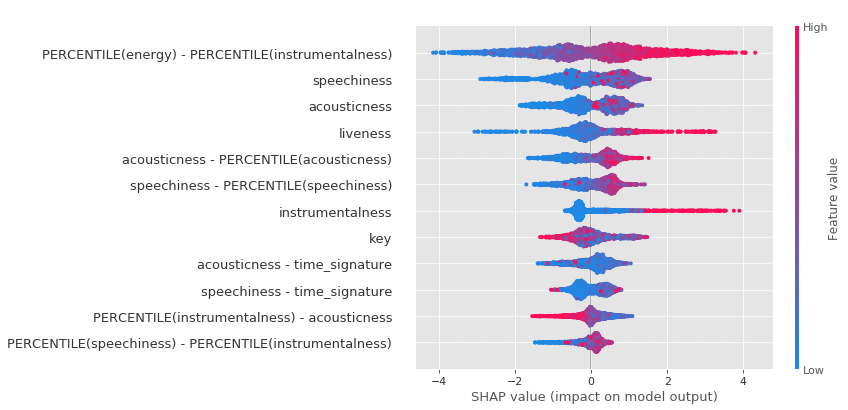

In [73]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

# Sentiment Analysis with Vader

In [394]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
analyzer = SentimentIntensityAnalyzer()

In [663]:
polarity_dic = {}

for sentence in all_lyrics.text:
    vader_sentiment = analyzer.polarity_scores(sentence).items()
    sent_list = []
    for sentiment in vader_sentiment:
        sent_list.append(sentiment[1])
        
    polarity_dic[sentence] = sent_list

In [664]:
lyrics = all_lyrics.join(pd.DataFrame(list(polarity_dic.values())).rename(columns = {0:'neg', 1:'neu',2:'pos', 3:'compound'}))

In [665]:
# lyrics.to_csv('lyrics_data/lyrics.txt')

In [666]:
kpop_df = kpop_df.rename(columns = {'song_name_formatted':'name'})

In [667]:
df = pd.merge(kpop_df, lyrics, on = 'name')

In [668]:

df = df.dropna()

In [669]:
df.groupby('artist_name').agg({'neg':'mean', 'neu':'mean','pos':'mean','compound':'mean'})

,neg,neu,pos,compound
artist_name,,,,
aoa,0.088167,0.750833,0.160833,0.411733
bigbang,0.136000,0.608286,0.255714,0.995771
bts,0.123360,0.705829,0.170994,0.342491
girls generation,0.078250,0.702042,0.219333,0.912133
ikon,0.089000,0.790000,0.121000,0.011900
red velvet,0.100000,0.729000,0.171000,0.983400
shinee,0.059510,0.753184,0.187327,0.816151
wanna one,0.049533,0.777400,0.172533,0.981640


In [856]:
# bts = df[df.artist_name == 'bts']

# scatter_matrix(bts[['neg','pos','neu','energy','speechiness','acousticness','liveness','year']], alpha = 0.25, figsize = (15,15), diagonal = 'hist');


In [857]:
# colors = ['red' if ix else 'blue' for ix in df.target]
# scatter_matrix(df[['danceability','energy','speechiness','acousticness','liveness','neg','year','pos','neu']], alpha = 0.25, figsize = (15,15), diagonal = 'hist', color = colors);
# suptitle('Scatter matrix of musical features via-a-vis lyrical sentiment', size = 25);

In [ ]:
# all_lyrics.groupby('target').describe()